In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import random
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
%matplotlib inline

In [15]:
args = {
    'noise':0.01,
    'train size':0.7,
    'spec scale':10**12,
    'scaler':RobustScaler(),
    }

param_grid = {
    'optimizer' : [torch.optim.Rprop],
    'optimizer__lr' : [0.01],
    'max_epochs' : [5000],
    'module__hidden1_size' : [27, 30, 35, 45, 60],
    'module__hidden2_size' : [6, 9, 15, 18, 21]
}

In [16]:
df = pd.read_excel('data_3nm.xlsx')

In [17]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [18]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [19]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [20]:
# add noise
X_noisy = add_noise(X, args['noise'])

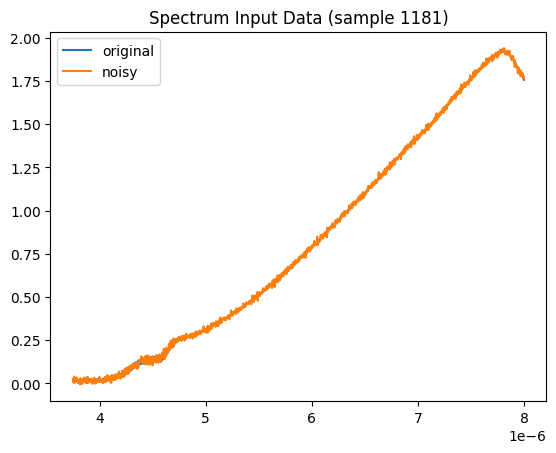

In [21]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [22]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [23]:
X_tensor = torch.tensor(X_noisy_scaled_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [24]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden1_size, hidden2_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, hidden1_size)
        self.lin2 = nn.Linear(hidden1_size, hidden2_size)
        self.lin_fin = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = self.lin_fin(x)
        return x

In [25]:
input_size = len(X.columns)
output_size = len(y.columns)

In [26]:
net = NeuralNetRegressor(
    module=Net,
    module__input_size=input_size,
    module__output_size=output_size,
    module__hidden1_size=45,
    module__hidden2_size=9,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

gs = GridSearchCV(net, param_grid, scoring='neg_mean_absolute_error', cv=5, verbose=3, n_jobs=-1)

gs.fit(X_tensor, y_tensor)

best_model = gs.best_estimator_
best_params = gs.best_params_

print('Best loss: {}'.format(gs.best_score_))
print('Params: {}'.format(best_params))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
